In [1]:
import json
import csv

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import math

import sys
sys.path.append("../../")

import implicitmodules.torch as dm

In [2]:

torch.set_default_dtype(torch.float64)

In [3]:
path_datafiles = '/home/gris/Data/2DShapes/'
path_names = path_datafiles + 'NamesPLAINTEXT/'

names = []
with open(path_names + 'labels.txt', 'r') as namelist:
    for line in namelist:
        names.append(line[:-1])

In [4]:
ind_shape = 6

names_subj = []
with open(path_names + 'ShapeNames/' + names[ind_shape] + '.txt', 'r') as namelist:
    for line in namelist:
        names_subj.append(line[:-1])


In [5]:
ind_subj = 0
path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
#subj = 

In [6]:
list_subj = []
list_indi_tri = []
list_majo = []
for ind_subj in range(len(names_subj)):
    path_subj = path_datafiles + 'ShapesJSON/Shapes/' + names_subj[ind_subj] + '.json'
    with open(path_subj) as f:
        subj_dict = json.load(f)
        Npts = len(subj_dict['points'])
        subj = []
        for i in range(Npts-1):
            subj.append([subj_dict['points'][i]['x'], subj_dict['points'][i]['y']])

        list_subj.append(np.array(subj))
        
        indi_tri = []
        Ntri = len(subj_dict['triangles'])
        for i in range(Ntri):
            indi_tri.append([subj_dict['triangles'][i]['p1'],subj_dict['triangles'][i]['p2'],subj_dict['triangles'][i]['p3']])
        list_indi_tri.append(np.array(indi_tri))
     
    path_majo = path_datafiles + 'MajorityJSON/Majority/' + names_subj[ind_subj] + '.json'
    with open(path_majo) as f:
        list_majo.append(json.load(f))

(-0.03802, 0.7984199999999999, -0.05, 1.05)

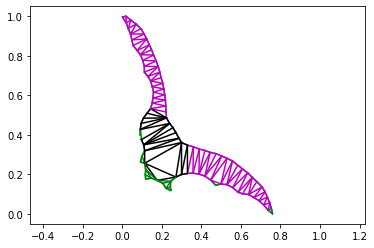

In [7]:
ind_subj = 2
subj = list_subj[ind_subj]
indi_tri = list_indi_tri[ind_subj]
majo_dict = list_majo[ind_subj]

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    #plt.gca().add_patch(t1)
plt.axis('equal')

(-0.05, 1.05, -0.048819, 1.025199)

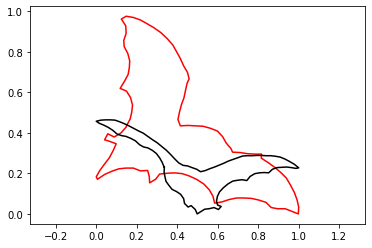

In [21]:
ind_subj_source = 0
subj = list_subj[ind_subj_source]
indi_tri = list_indi_tri[ind_subj_source]
majo_dict = list_majo[ind_subj_source]
plt.plot(subj[:,0], subj[:,1], '-r')

ind_subj_target = 1
subj = list_subj[ind_subj_target]
indi_tri = list_indi_tri[ind_subj_target]
majo_dict = list_majo[ind_subj_target]
plt.plot(subj[:,0], subj[:,1],'k')

plt.axis('equal')

In [22]:
source = torch.tensor(list_subj[ind_subj_source])
target = torch.tensor(list_subj[ind_subj_target])

# Matching with LDDMM

In [23]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [24]:
sigma = 0.05
translations = dm.DeformationModules.ImplicitModule0(2, source.shape[0], sigma, nu=0.1, gd=source.clone().requires_grad_())

In [25]:
sigmas_varifold = [0.1, 1.]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [26]:
# model = dm.Models.RegistrationModel([source_deformable], [rotation], [dm.Attachment.GeomlossAttachment(loss='sinkhorn', blur=0.05, scaling=0.9)], fit_gd=[True], lam=100.)
model = dm.Models.RegistrationModel([source_deformable], [translations], [attachment], fit_gd=[False], lam=100.)

In [27]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(211.5087)}
Time: 10.535109426999952
Iteration: 0
Costs
deformation=0.20236719644878307
attach=3.1367976798004626
Total cost=3.339164876249246
Time: 19.317083895999986
Iteration: 1
Costs
deformation=0.0892608071937389
attach=0.28194031047414914
Total cost=0.37120111766788805
Time: 28.335017761000017
Iteration: 2
Costs
deformation=0.08338743284497692
attach=0.1026602222617301
Total cost=0.186047655106707
Time: 37.75119248200008
Iteration: 3
Costs
deformation=0.06120131238431087
attach=0.055782965861550515
Total cost=0.11698427824586138
Time: 47.230367895999734
Iteration: 4
Costs
deformation=0.04760007977112435
attach=0.03619911193362135
Total cost=0.0837991917047457
Time: 56.40185784100004
Iteration: 5
Costs
deformation=0.03272998132393565
attach=0.03071885755572268
Total cost=0.06344883887965833
Time: 65.35132901399993
Iteration: 6
Costs
deformation=0.02480416716738726
attach=0.028372

In [28]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.05, 1.05, -0.048819, 1.025199)

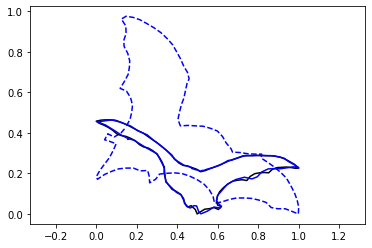

In [29]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], 'b')
plt.axis('equal')

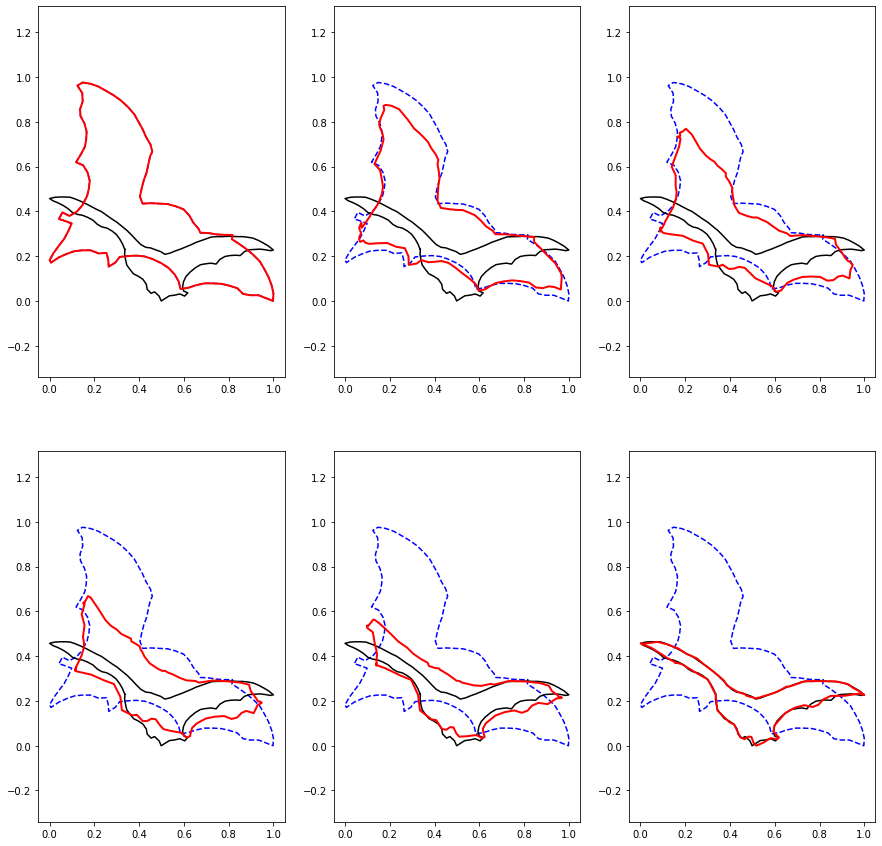

In [31]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
    plt.plot(intermediates['states'][2*i].gd[1].detach().numpy()[:,0], intermediates['states'][2*i].gd[1].detach().numpy()[:,1], 'r', linewidth=2)
    plt.axis('equal')

# Matching with growth model

In [32]:
aabb = dm.Utilities.aabb.AABB.build_from_points(source)

In [33]:
aabb.scale_([1.5, 2])

In [34]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)


(-0.05, 1.05, -0.048819, 1.025199)

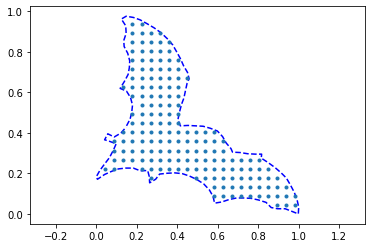

In [35]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.axis('equal')

(-0.05, 1.05, -0.048819, 1.025199)

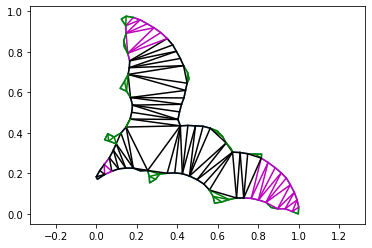

In [36]:
subj = list_subj[ind_subj_source]
indi_tri = list_indi_tri[ind_subj_source]
majo_dict = list_majo[ind_subj_source]

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    #plt.gca().add_patch(t1)
plt.axis('equal')

In [37]:
indi_left = range(0, 36)
#indi_left0 = range(0, 28)
#indi_left1 = range(80, 104)
indi_right = range(40, 80)

#part_left = np.concatenate([source[indi_left1, :], source[indi_left0, :]], axis = 0)
part_left = source[indi_left, :]
part_right = source[indi_right, :]

(-0.05, 1.05, -0.048819, 1.025199)

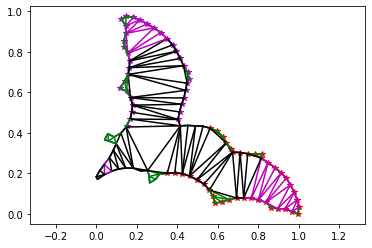

In [38]:
plt.plot(source[:,0], source[:,1], 'k')
plt.plot(part_left[:,0], part_left[:,1], '*m')
plt.plot(part_right[:,0], part_right[:,1], '*r')

col = ['k', 'm', 'g']
plt.plot(subj[:,0], subj[:,1])
for i in range(np.shape(indi_tri)[0]):
    plt.plot(subj[indi_tri[i],0], subj[indi_tri[i],1], col[majo_dict['majority'][i]])
    t1 = plt.Polygon(subj[indi_tri[i],:], color=col[majo_dict['majority'][i]])
    
plt.axis('equal')

In [39]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)
points_growthleft = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_left), intersect=True)
points_growthright = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_right), intersect=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [40]:
indi_growth_left = range(0,points_growthleft.shape[0] +2)
indi_growth_right = range(points_growth.shape[0]-points_growthright.shape[0], points_growth.shape[0])
indi_growth_main = range(points_growthleft.shape[0] +2,points_growth.shape[0]-points_growthright.shape[0])

(-0.05, 1.05, -0.048819, 1.025199)

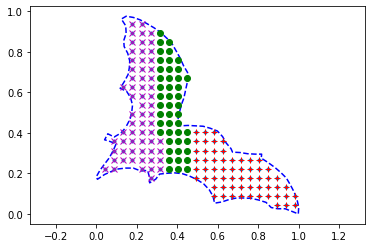

In [41]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.plot(points_growth[indi_growth_left,0], points_growth[indi_growth_left,1], 'xm')
plt.plot(points_growth[indi_growth_right,0], points_growth[indi_growth_right,1], '+r')
plt.plot(points_growth[indi_growth_main,0], points_growth[indi_growth_main,1], 'og')
plt.axis('equal')

In [21]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 3)
C[indi_growth_left, 0, 0] = 1.
C[indi_growth_right, 0, 1] = 1.
C[indi_growth_main, 0, 2] = 1.
C[indi_growth_main, 1, 2] = 1.

In [42]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 1)
C[:, 0, 0] = 1.

In [43]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
#rot_growth[indi_growth_left]= torch.stack([dm.Utilities.rot2d(-0.25*math.pi)])

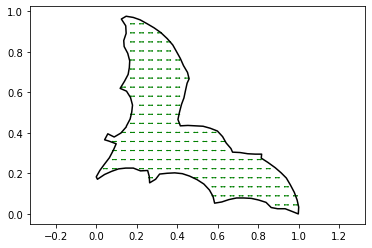

In [44]:
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_growth, c_index=0, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [45]:
scale_growth = 0.2
coeff_growth = 1.
nu = 0.001
#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

In [31]:
#%matplotlib qt5
C1 = torch.zeros(points_growth.shape[0], 2, 3)
C1[indi_growth_left, 0, 0] = 1.
C1[indi_growth_right, 0, 1] = 1.
C1[indi_growth_main, 0, 2] = 1.
C1[indi_growth_main, 1, 2] = 1.

In [32]:
points_growth1 = points_growth.clone().detach().requires_grad_()

In [33]:
rot_growth1 = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

In [34]:
scale_growth1 = 0.2
coeff_growth1 = 1.
nu1 = 0.001
#growth = dm.DeformationModules.ImplicitModule1(
#    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, coeffcont=100., nu=nu,
#    gd=(points_growth, rot_growth))
growth1 = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth1, C1, coeff=coeff_growth1, nu=nu1,
    gd=(points_growth1, rot_growth1))

In [46]:
rotation = dm.DeformationModules.LocalRotation(2, 2., gd=torch.tensor([[0., 0.]]).requires_grad_())

In [47]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [48]:
source_deformable = dm.Models.DeformablePoints(source)
target_deformable = dm.Models.DeformablePoints(target)

In [49]:
sigmas_varifold = [0.1, 1.]
attachment = dm.Attachment.VarifoldAttachment(2, sigmas_varifold)

In [50]:

def rot2d_vec(thetas):
    assert len(thetas.shape) == 1
    sin = torch.sin(thetas)
    cos = torch.cos(thetas)

    return torch.stack([torch.stack([cos, -sin], dim=1),
                        torch.stack([sin, cos], dim=1)], dim=2)


In [51]:
def precompute(init_manifold, modules, parameters):
    basis = rot2d_vec(parameters['angles']['params'][0][:, 0])
    init_manifold[3].gd = (init_manifold[3].gd[0], basis)

    #basis = rot2d_vec(parameters['angles']['params'][1][:, 0])
    #init_manifold[4].gd = (init_manifold[4].gd[0], basis)

angles = torch.zeros(points_growth.shape[0], 1, requires_grad=True)
angles1 = torch.zeros(points_growth.shape[0], 1, requires_grad=True)

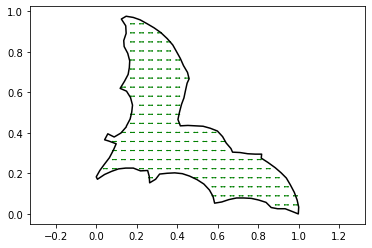

In [52]:
rot_g = rot2d_vec(angles[:,0])
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_g.detach(), c_index=0, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [53]:
#modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.)
modelgrowth = dm.Models.RegistrationModel([source_deformable], [global_translation, rotation, growth], [attachment], fit_gd=[False], lam=10.,precompute_callback=precompute, other_parameters={'angles': {'params': [angles, angles1]}})

In [54]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit([target_deformable], 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(21.1509)}
Time: 210.66328678400077
Iteration: 0
Costs
deformation=3.0858224768236644
attach=3.7644626072148735
Total cost=6.850285084038537
Time: 555.2543681480001
Iteration: 1
Costs
deformation=1.2338599921045343
attach=3.331763365746603
Total cost=4.565623357851138
Time: 793.7040694830002
Iteration: 2
Costs
deformation=0.163675627049186
attach=2.4276213830714144
Total cost=2.5912970101206003
Time: 957.3101379700001
Iteration: 3
Costs
deformation=0.06595397449491695
attach=1.9128410627807457
Total cost=1.9787950372756626
Time: 1117.250201465
Iteration: 4
Costs
deformation=0.07632840727342316
attach=1.4785843921042274
Total cost=1.5549127993776506
Time: 1275.4718431480005
Iteration: 5
Costs
deformation=0.012487513431347734
attach=1.2034546948040137
Total cost=1.2159422082353615
Time: 1439.0474412430003
Iteration: 6
Costs
deformation=0.018938239791672706
attach=1.1202900218188172
Tota

KeyboardInterrupt: 

In [55]:
intermediates = {}
with torch.autograd.no_grad():
    deformed_source = modelgrowth.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)[0][0]


(-0.06777102876513655, 1.0508462394650064, -0.048819, 1.025199)

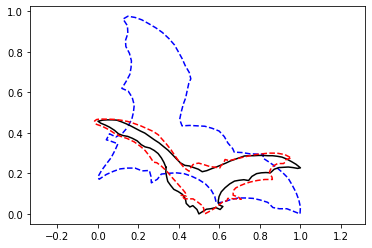

In [56]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(deformed_source.detach().numpy()[:,0], deformed_source.detach().numpy()[:,1], '--r')
plt.axis('equal')

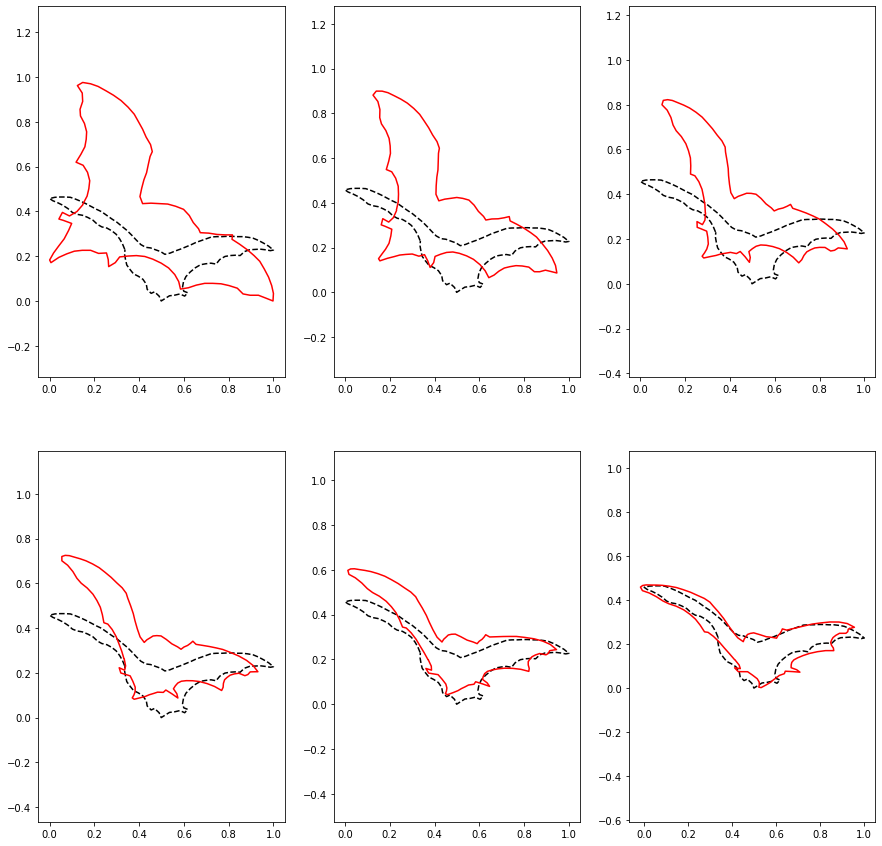

In [64]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    #if i<5:
    #    #print(intermediates['controls'][2*i][3])
    #plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates['states'][2*i].gd[0].detach().numpy()[:,0], intermediates['states'][2*i].gd[0].detach().numpy()[:,1], 'r')
    plt.axis('equal')

In [65]:
for i in range(10):
    print(intermediates['controls'][i][3])

tensor([-1.5035])
tensor([-1.6189])
tensor([-1.5715])
tensor([-1.3862])
tensor([-1.1591])
tensor([-0.9616])
tensor([-0.8106])
tensor([-0.6922])
tensor([-0.5948])
tensor([-0.5127])


In [68]:
angles[:,0]/math.pi

tensor([-0.2815, -0.2233, -0.1767, -0.1393, -0.1111, -0.1266, -0.0988, -0.0786,
        -0.0612, -0.0056, -0.0838, -0.0635, -0.0472, -0.0311, -0.0148,  0.0003,
         0.0130,  0.0063, -0.0053, -0.0173, -0.0277, -0.0362, -0.0389, -0.0336,
        -0.0227, -0.0746, -0.0557, -0.0409, -0.0262, -0.0099,  0.0060,  0.0190,
         0.0258,  0.0242,  0.0154,  0.0032, -0.0089, -0.0201, -0.0305, -0.0378,
        -0.0390, -0.0342, -0.0682, -0.0558, -0.0432, -0.0319, -0.0177, -0.0011,
         0.0146,  0.0264,  0.0313,  0.0281,  0.0185,  0.0065, -0.0051, -0.0160,
        -0.0259, -0.0335, -0.0359, -0.0505, -0.0417, -0.0318, -0.0178, -0.0012,
         0.0141,  0.0254,  0.0300,  0.0265,  0.0170,  0.0059, -0.0047, -0.0147,
        -0.0236, -0.0291, -0.0291, -0.0527, -0.0453, -0.0354, -0.0211, -0.0047,
         0.0105,  0.0221,  0.0271,  0.0239,  0.0150,  0.0045, -0.0057, -0.0160,
        -0.0253, -0.0290, -0.0570, -0.0495, -0.0388, -0.0239, -0.0073,  0.0085,
         0.0211,  0.0270,  0.0245,  0.01

In [60]:
rot_opt = rot2d_vec(angles[:,0])

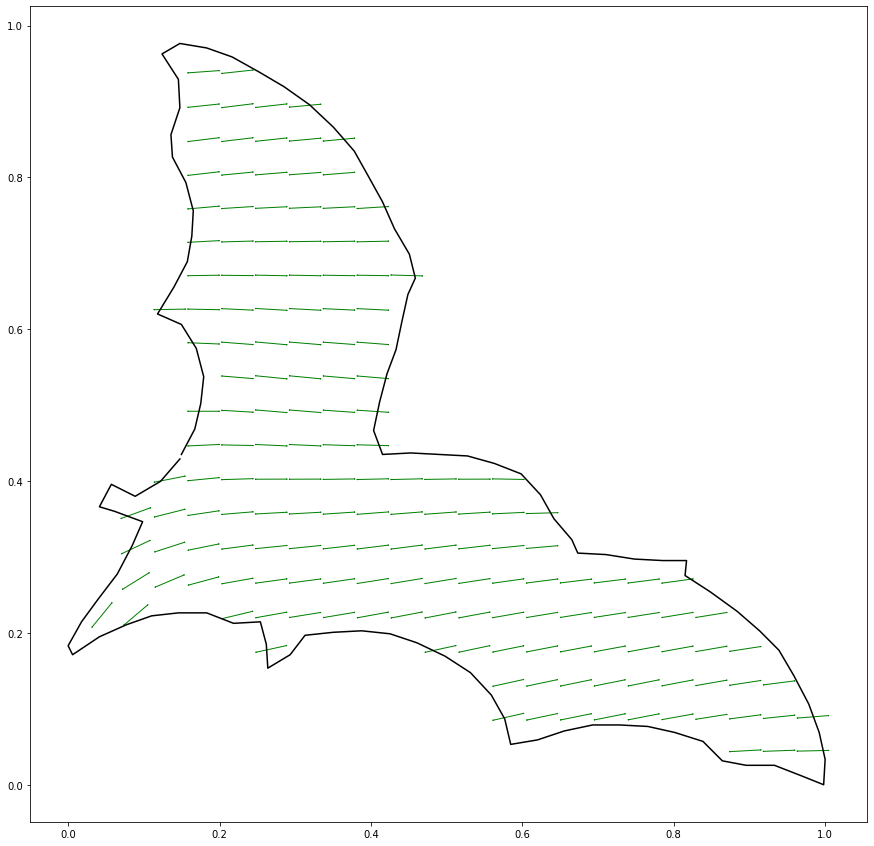

In [63]:

f = plt.figure(figsize=(15,15))
ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, R=rot_opt.detach(), c_index=0, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()

In [133]:
sum([intermediates['controls'][i][3] for i in range(10)])

tensor([-1.4724, -0.9232, -0.8754])

In [134]:
for i in range(10):
    print(intermediates['controls'][i][3])

tensor([-0.1470, -0.0912, -0.0962])
tensor([-0.1509, -0.0921, -0.0954])
tensor([-0.1545, -0.0929, -0.0945])
tensor([-0.1570, -0.0937, -0.0931])
tensor([-0.1578, -0.0942, -0.0912])
tensor([-0.1559, -0.0943, -0.0887])
tensor([-0.1510, -0.0937, -0.0855])
tensor([-0.1431, -0.0925, -0.0816])
tensor([-0.1331, -0.0906, -0.0771])
tensor([-0.1221, -0.0881, -0.0722])


In [135]:
# We extract the modules of the models and fill the right manifolds.
silent = dm.DeformationModules.SilentBase(copy.copy(modelgrowth.init_manifold.clone().manifolds[0]), label='sil')
modules = dm.DeformationModules.CompoundModule(copy.copy(modelgrowth.modules))
modules.manifold.fill(modelgrowth.init_manifold.clone(), copy=True)
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
#translation = copy.copy(modelgrowth.modules[0])
#growth2 = copy.copy(modelgrowth.modules[1])

In [136]:
CompoundModule = dm.DeformationModules.CompoundModule([deformation_grid] + modules.modules)

In [137]:
# We construct the controls list we will give will shooting
controls = [[torch.tensor([]), torch.tensor([]), 0.*control[1], 0.*control[2], torch.tensor([0.*control[3][0], 1.*control[3][1], 0.*control[3][2]])] for control in intermediates['controls']]

In [138]:
intermediates_cont = {}
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(CompoundModule.modules), shoot_solver, shoot_it, controls=controls, intermediates=intermediates_cont)

In [139]:
growth_deformed_source = silent.manifold.gd.detach()
growth_deformed_grid = deformation_grid.togrid()

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


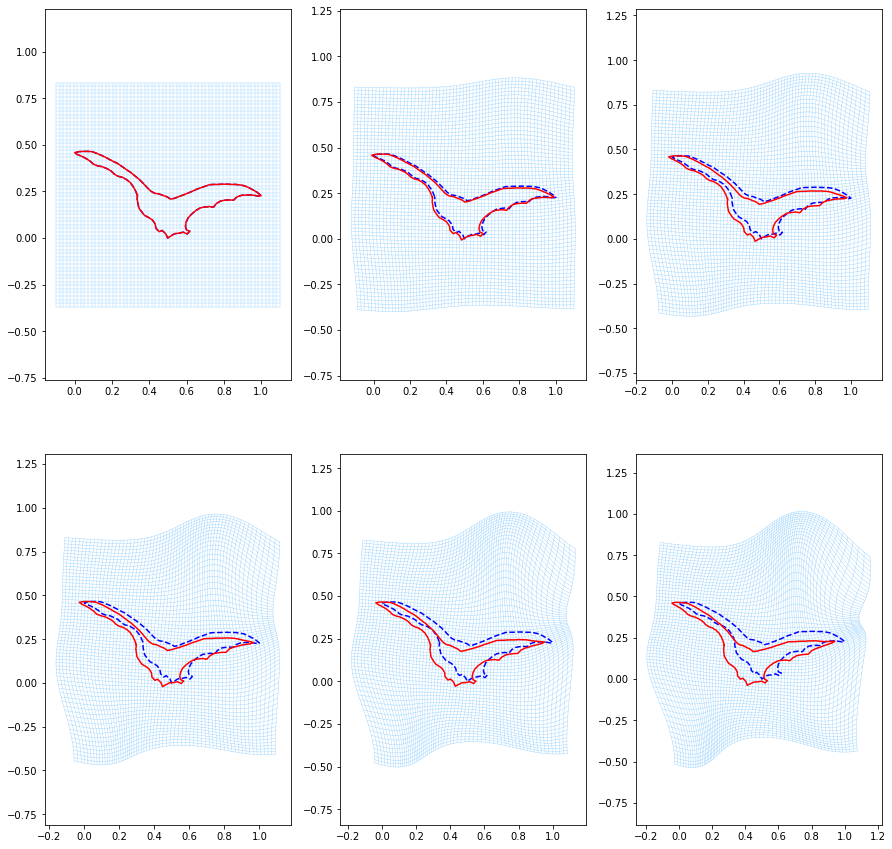

In [140]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(-0.)


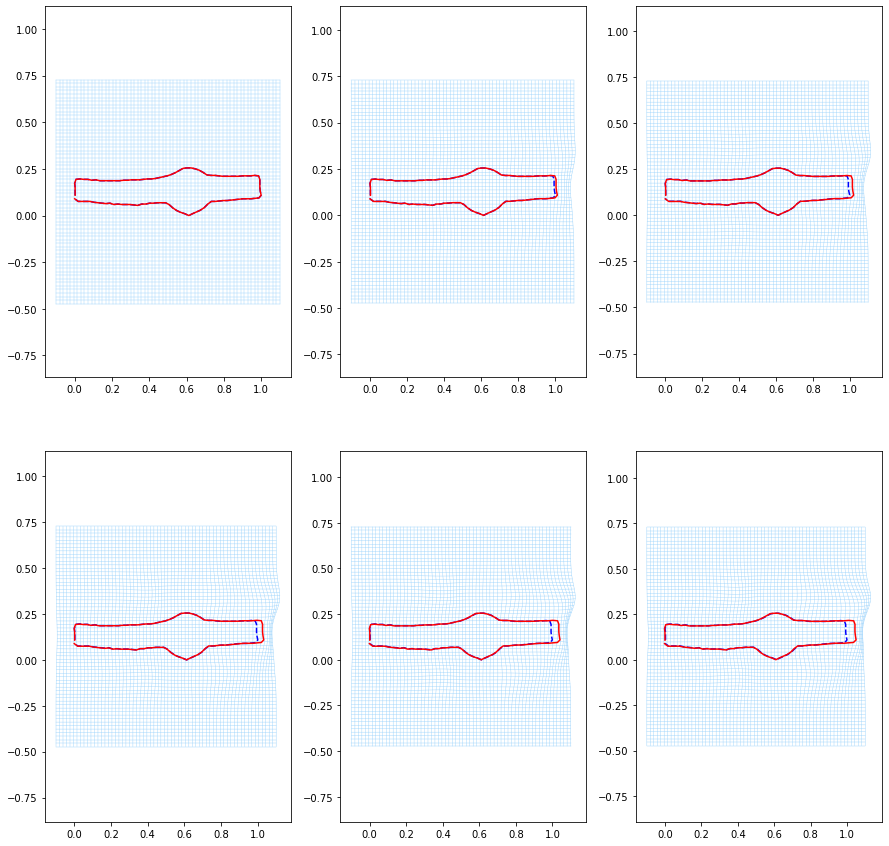

In [81]:
f = plt.figure(figsize=(15,15))
for i in range(6):
    ax = f.add_subplot(2,3,i+1)
    if i<5:
        print(intermediates_cont['controls'][2*i][3])
    deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
    deformation_grid_t.manifold.fill_gd(intermediates_cont['states'][2*i].gd[0].detach())
    growth_deformed_grid_t = deformation_grid_t.togrid()
    dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
    plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
    #plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], '--k')
    plt.plot(intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,0], intermediates_cont['states'][2*i].gd[1].detach().numpy()[:,1], 'r')
    plt.axis('equal')

(-0.2099575578392855,
 1.3644548670464338,
 -0.5323633347340097,
 0.7877051311809289)

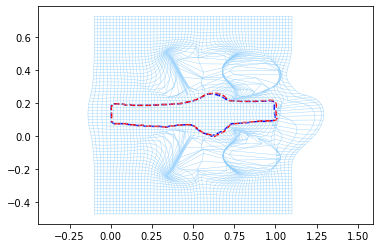

In [75]:
#%matplotlib qt5
ax = plt.subplot(1, 1, 1)
plt.plot(source.detach().numpy()[:, 0], source.detach().numpy()[:, 1], '--b')
#plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'k')
plt.plot(growth_deformed_source[:, 0].numpy(), growth_deformed_source[:, 1].numpy(), '--r')
dm.Utilities.plot_grid(ax, growth_deformed_grid[0], growth_deformed_grid[1], color='xkcd:light blue', lw=0.4)
plt.axis('equal')


# Working on images

In [11]:
source_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch01.png', origin='lower')
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch03.png', origin='lower')

In [34]:
source_image.shape

torch.Size([202, 500])

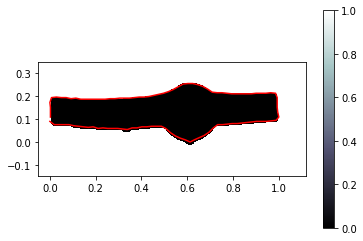

In [12]:

extent_source = dm.Utilities.AABB( -0.05, 1.12,-0.15, 0.35)

plt.imshow(source_image.numpy(), origin='lower', cmap='bone', extent=extent_source.totuple())
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], 'r')
plt.colorbar()

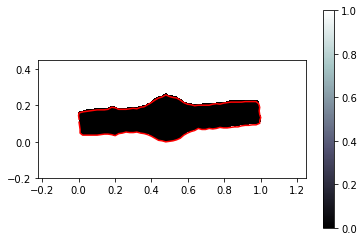

In [13]:
extent_target = dm.Utilities.AABB( -0.22, 1.25,-0.2, 0.45)
target_image = dm.Utilities.load_greyscale_image( path_datafiles + 'Images/watch11.png', origin='lower')
plt.imshow(target_image.numpy(), origin='lower', cmap='bone', extent=extent_target.totuple())
plt.plot(target.detach().numpy()[:,0], target.detach().numpy()[:,1], 'r')
plt.colorbar()

In [14]:
indi_left0 = range(0, 28)
indi_left1 = range(80, 104)
indi_right = range(37, 69)

part_left = np.concatenate([source[indi_left1, :], source[indi_left0, :]], axis = 0)
part_right = source[indi_right, :]

In [15]:
aabb_source = dm.Utilities.AABB.build_from_points(source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=source)
points_growthleft = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_left), intersect=True)
points_growthright = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 500, shape=torch.tensor(part_right), intersect=True)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [16]:
indi_growth_left = range(0,points_growthleft.shape[0] +2)
indi_growth_right = range(points_growth.shape[0]-points_growthright.shape[0], points_growth.shape[0])

(-0.05, 1.05, -0.012766, 0.268086)

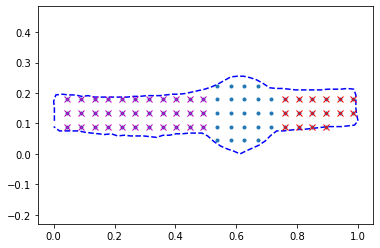

In [17]:
plt.plot(source.detach().numpy()[:,0], source.detach().numpy()[:,1], '--b')
plt.plot(points_growth[:,0], points_growth[:,1], '.')
plt.plot(points_growth[indi_growth_left,0], points_growth[indi_growth_left,1], 'xm')
plt.plot(points_growth[indi_growth_right,0], points_growth[indi_growth_right,1], 'xr')
plt.axis('equal')

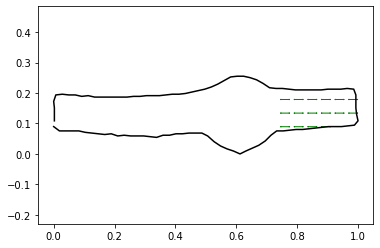

In [18]:
#%matplotlib qt5
C = torch.zeros(points_growth.shape[0], 2, 2)
C[indi_growth_left, 0, 0] = 1.
C[indi_growth_right, 0, 1] = 1.

ax = plt.subplot()
dm.Utilities.plot_C_arrows(ax, points_growth, C, c_index=1, color='green', scale=0.05)
plt.plot(source[:, 0].numpy(), source[:, 1].numpy(), color='black')
plt.axis('equal')
plt.show()


In [19]:
rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)
scale_growth = 0.1
coeff_growth = 1.
nu = 0.001
growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth, rot_growth))

In [20]:
global_translation = dm.DeformationModules.GlobalTranslation(2)

In [21]:
source_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent=extent_source)
target_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent=extent_target)

In [22]:

source_image_deformable = dm.Models.DeformableImage(source_image, output='bitmap',
                                              extent=extent_source)
target_image_deformable = dm.Models.DeformableImage(target_image, output='bitmap',
                                              extent=extent_target)


In [23]:
attachment_image = dm.Attachment.EuclideanPointwiseDistanceAttachment()

In [31]:
target_image_deformable.geometry[0].shape

torch.Size([224, 520])

In [30]:
source_image_deformable.geometry[0].shape

torch.Size([202, 500])

In [26]:
attachment_image(source_image_deformable.geometry, target_image_deformable.geometry)

RuntimeError: The size of tensor a (500) must match the size of tensor b (520) at non-singleton dimension 1

In [81]:
modelgrowth_image = dm.Models.RegistrationModel([source_image_deformable], [global_translation, growth], [attachment_image], fit_gd=[False], lam=100.)

In [83]:
shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(modelgrowth_image, optimizer='torch_lbfgs')
# fitter = dm.Models.Fitter(model, optimizer='scipy_l-bfgs-b')
fitter.fit(target_image_deformable, 20, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

KeyboardInterrupt: 